<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 5: Modelos de difusión

### MDS7203 Modelos Generativos Profundos

**Nombre:**

**Fecha de entrega:**

En esta quinta tarea se evaluarán los contenidos asociados a modelos de difusión. Para esto, se implementarán algunas funciones asociadas al modelo Stable Diffusion.

Algunas instrucciones generales:

- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- Esta tarea debe ser resuelta utilizando Google Colab.
- La tarea está compuesta por tres partes. Todas las partes valen lo mismo.

In [1]:
import requests
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, utils
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parte 1: Modelo Stable Diffusion

En esta primera parte se cargará el modelo Stable Diffusion 1.4 y se revisarán sus componentes.

In [2]:
model_id = "CompVis/stable-diffusion-v1-4"

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


- Implemente la función `count_parameters` para contar la cantidad de parámetros de los modelos anteriores.

In [68]:
def count_parameters(model):
    ...

print(f"CLIP Text Encoder: {count_parameters(text_encoder)} parámetros.")
print(f"VAE: {count_parameters(vae)} parámetros.")
print(f"U-Net: {count_parameters(unet)} parámetros.")


CLIP Text Encoder: None parámetros.
VAE: None parámetros.
U-Net: None parámetros.


In [69]:
prompt = 'perrito sentado'
text_input = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True)
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [70]:
print(text_input)
print(text_input['input_ids'])
print('dimension text_input: ', text_input['input_ids'].shape)
print('dimension text_embeddings: ', text_embeddings.shape)


{'input_ids': tensor([[49406,   703, 19379,  6200,  2933, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
tensor([[49406,   703, 19379,  6200,  2933, 49407]])
dimension text_input:  torch.Size([1, 6])
dimension text_embeddings:  torch.Size([1, 6, 768])


### CLIP Text encoder

El tokenizador y el embedding de texto pueden usarse de la siguiente forma:

```
prompt = <texto para guiar la generación>
text_input = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True)
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
```

- ¿Qué tokenizador utiliza el modelo CLIP?
> **Respuesta:**
El  tkenizador de CLIP está basado en un Byte-Pair-Encoder (BPE), el mismo que utiliza GPT-2. Este tokeniza a partir de "subpalabras", formadas a partir de divisiones de la palabras por sílabas o unidades más pequeñas.

- ¿Qué elementos contiene el objeto `text_input`?
> **Respuesta:**
`text_input` es un diccionario que contiene `ìnput_ids`, es decir los ID de los tokens generados, y `attention_mask` un vector quee tiene el valor 1 si al token en esa posición se le debe poner atención, 0 en caso contrario.

- ¿Cuál es la dimensión del tensor `text_input["input_ids"]`? ¿Qué indica este valor?
> **Respuesta:**
Es un tensor de dim (1,6), esto quiere decir que se generan oraciones con 6 tokens, donde el primero y último de estos son tokens especiales para denotar el inicio y final de la oración.

- ¿Cuál es la dimensión de embedding del modelo CLIP?
> **Respuesta:**
Según `text_embeddings` (revisado arriba), este tiene dimensión 768.

- ¿Cuál es la diferencia entre usar un embedding tipo CLIP y un embedding tipo BERT?
> **Respuesta:**
Usar un embedding de tipo BERT permite captar el significado y contexto de un texto, por lo que es muy útil para la predcicción de palabras. Mientras que CLIP permite relacionar texto con su imagen correspondiente

- Implemente la función `cosine_similarity` para evaluar la similitud de dos cadenas de texto a partir de sus embeddings generados por el modelo CLIP.





In [71]:
def cosine_similarity(p1, p2, tokenizer, encoder):
  input_1 = tokenizer([p1], return_tensors="pt", padding=True, truncation=True).to(device)
  input_2 = tokenizer([p2], return_tensors="pt", padding=True, truncation=True).to(device)

  with torch.no_grad():
    out1 = encoder(**input_1)
    out2 = encoder(**input_2)

    # Calculamos out2.pooler_output[0], que corresponde al vector de embedding para
    # la oracion tokenizada, no se puede usar solo encoder(**input2) porque también
    # entrega un tensor con los embeddings de cada token.
    emb_1 = out1.pooler_output[0]
    emb_2 = out2.pooler_output[0]

    norm_1 = torch.norm(emb_1)
    norm_2 = torch.norm(emb_2)

  # Similitud coseno: a*b/( ||a||*||b||)
  return torch.dot(emb_1, emb_2)/(norm_1 * norm_2)

# Prompts:
prompt_a = "A photo of a red sports car driving on a mountain road"
prompt_b = "A photograph of a luxury car speeding on a hill highway"
prompt_c = "A portrait of a medieval queen in oil painting style"

# Similitud:
sim_ab = cosine_similarity(prompt_a, prompt_b, tokenizer, text_encoder)
sim_ac = cosine_similarity(prompt_a, prompt_c, tokenizer, text_encoder)
sim_bc = cosine_similarity(prompt_b, prompt_c, tokenizer, text_encoder)

print(f"Similitud(a, b): {sim_ab:.4f}")
print(f"Similitud(a, c): {sim_ac:.4f}")
print(f"Similitud(b, c): {sim_bc:.4f}")

Similitud(a, b): 0.6739
Similitud(a, c): 0.1487
Similitud(b, c): 0.1718


### VAE

El modelo Stable Diffusion realiza el proceso de difusión en el espacio latente de un VAE. El siguiente código muestra como utilizar este VAE, el cual espera recibir una imagen de tamaño $512\times512\times3$:


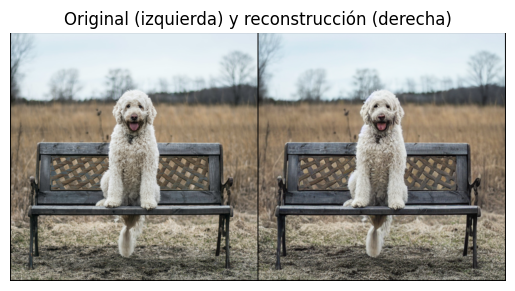

In [72]:
def load_image_from_url(url, size=(512, 512), mode="RGB"):
    img = Image.open(requests.get(url, stream=True).raw).convert(mode)
    img = img.resize(size, Image.BICUBIC)
    return img

def preprocess(img_pil):
    to_tensor = transforms.ToTensor()
    x = to_tensor(img_pil).unsqueeze(0).to(device)
    return 2.0 * x - 1.0

# Ejemplo:
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
img_pil = load_image_from_url(image_url)
x = preprocess(img_pil)

# Reconstrucción:
with torch.no_grad():
    z = vae.encode(x).latent_dist.sample()
    x_rec = vae.decode(z).sample
    x_rec = (x_rec.clamp(-1, 1) + 1) / 2

# Visualización:
grid = utils.make_grid(torch.cat([x.clamp(-1,1).add(1).div(2), x_rec], dim=0), nrow=2)
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis("off")
plt.title("Original (izquierda) y reconstrucción (derecha)")
plt.show()

- ¿Qué normalización se le realiza a la imagen antes de entrar al VAE?
> **Respuesta:**
- ¿Cuál es la dimensión latente asociada a este VAE?
> **Respuesta:**

#### U-Net

Para el proceso de denoising, el modelo de difusión utiliza una arquitectura tipo U-Net. En el siguiente código se verificará que la dimensión de salida corresponde con lo que se espera obtener.

- Asigne los valores a las variables `latent_channels` (canales de la variable latente), `height` y `width` (resolución de la variable latente), y `context_dim` (dimensión del embedding de CLIP).

In [73]:
batch_size = 1
latent_channels = 4
height = width = 64
context_dim = 768

# Tensores aleatorios:
z_t = torch.randn(batch_size, latent_channels, height, width).to(device)
t = torch.tensor([50]).to(device)
context = torch.randn(batch_size, 77, context_dim).to(device)

# Forward:
with torch.no_grad():
    output = unet(z_t, t, encoder_hidden_states=context)

assert output["sample"].shape == (batch_size, latent_channels, height, width)

- ¿Cómo es inyectado el tensor `context` en la arquitectura U-Net usada en Stable Diffusion?
> **Respuesta:**
- ¿Qué diferencia la arquitectura DiT de la arquitectura U-Net?
> **Respuesta:**

## Parte 2: Denoising

En esta segunda parte se implementará el proceso de denoising utilizando Stable Diffusion. Dado que este modelo es condicional, se realizará una generación condicional simple y luego una generación condicional utilizando classifier-free guidance.

#### DDIM Scheduler

Una de las principales limitaciones de los modelos de difusión es que el proceso reverso es costoso ya que se debe evaluar la red neuronal en cada tiempo de denoising. Una técnica que permite aminorar este problema es DDIM, la cual permite disminuir significativamente la cantidad de steps utilizados en el proceso reverso.

- Averigüe sobre el sampling realizado por DDIM y las diferencias que tiene con el enfoque DDPM estándar.
> **Respuesta:**
<!-- El DDIM aprovecha que los modelos implíticos no requieren de una expresión matemática explícita, sino que es el modelo el que define un conjunto de relaciones entre inputs y outputs sin especificarla. -->
En DDPM, el muestro se realiza mediante una cadena de Markov donde en cada paso se introduce ruido gaussiano. Su fómula de muestreo se basa en una dist condicional al paso anterior. Mientras que en DDIM, ya no se utilizan cadenas de Markov, aprovechando la ventaja de los Implicit Models. En este caso el muestreo deja de ser estocástico y puede ser determinista, ya que es capaz de saltar pasos en el proceso inverso (haciéndolo más rápido). Además, posee un parámetro $\eta$ que control que controla el ruido, si este se fija en 0 entonces ya no se incorpora ruido en cada paso, mientras que si es 1 entonces el modelo se parecerá a un DDPM.

In [74]:
n_steps = 50
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler.set_timesteps(n_steps, device=device)

#### Generación condicional simple

La siguiente función aplica el módulo de decoding de un VAE para una variable latente generada por el modelo de difusión:

In [75]:
def vae_decode(latents, plot_title):

    with torch.no_grad():
        latents_scaled = latents / vae.config.scaling_factor
        image = vae.decode(latents_scaled).sample
        image = (image.clamp(-1, 1) + 1) / 2

        grid = utils.make_grid(image, nrow=1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.axis("off")
        plt.title(plot_title)
        plt.show()

El modelo Stable Diffusion permite realizar generación condicional mediante la inyección de un texto (prompt) a la U-Net durante el proceso de denoising.

- Implemente la función `generate_sample`, la cual recibe una cadena de texto (`prompt`) y genera una nueva imagen utilizando la U-Net y el VAE estudiados en la primera parte. Visualice el proceso de denoising cada 10 iteraciones.

In [76]:
scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [77]:
def generate_sample(prompt):

  global tokenizer, scheduler, text_encoder, unet, vae_decode, context # llamo a los modelos y objetos que ya existen
  tokens = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

  with torch.no_grad():
    text_embedding = text_encoder(tokens)[0]

  # Inicializa ruido aleatorio latente
  # Agregamos la estructura tipo Unet para introducir ruido
  z = torch.randn(batch_size, latent_channels, height, width).to(device)

  # Scheduler ya tiene previamente cargado el numero de pasos de inferencia
  z_t = z * scheduler.init_noise_sigma

  for step, t in enumerate(scheduler.timesteps):
    # prediccion del ruido con la unet
    with torch.no_grad():
        ruido_predicho = unet(z_t, t.to(device), encoder_hidden_states=context)['sample']

    # Actualizacion de la variable latente
    z_t = scheduler.step(ruido_predicho.to(device), t, z_t).prev_sample

    # Visualización de imags cada 10 pasos
    if (step+1) % 10 == 0:
      with torch.no_grad():
        decoded = vae_decode(z_t, f'Step {step+1}/50') # vae_decode genera las imágenes


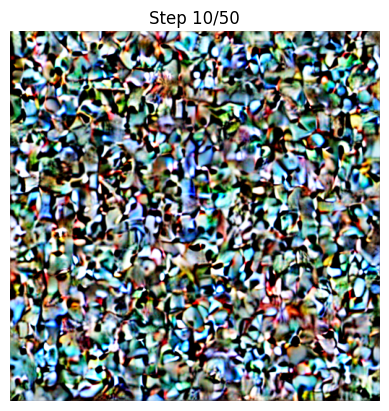

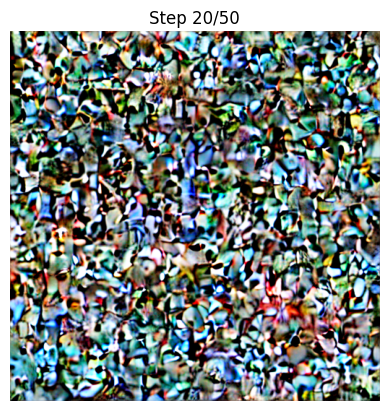

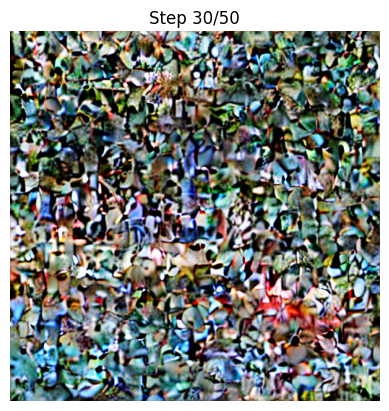

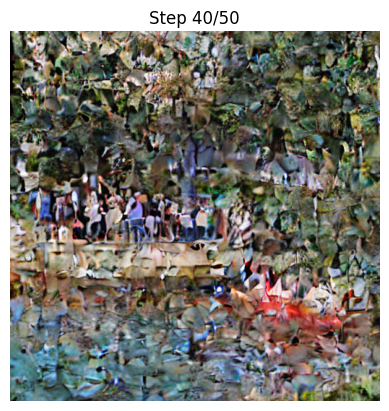

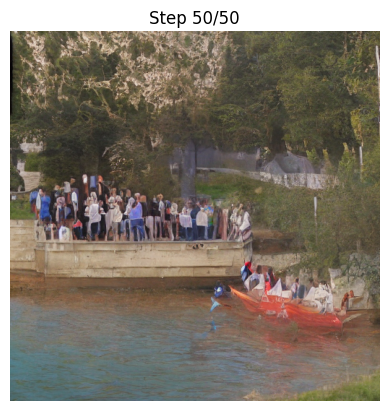

In [78]:
prompt = "A orange cat sitting on a park bench"
generate_sample(prompt)

#### Condicionamiento y guidance

Como se vio en clases, el condicionamiento simple no siempre permite generar muestras consistentes con el prompt. Una posible solución a este problema es utilizar la técnica de classifier-free guidance, la cual direcciona el ruido predicho en cada iteración para que la muestra final esté más ajustada al prompt.

- Implemente la función `generate_sample_guidance` para incluir el proceso de classifier-free guidance en la generación.

In [84]:
def generate_sample_guidance(prompt, guidance_scale):
  ...


In [85]:
prompt = "A yellow cat sitting on a park bench"
generate_sample_guidance(prompt, guidance_scale=8)

ValueError: not enough values to unpack (expected 2, got 1)

- ¿Qué desventaja tiene aumentar demasiado el factor de guidance?
> **Respuesta:**
- La técnica de classifier-free guidance también permite incluir prompts negativos en el proceso de generación. ¿Cómo se realiza esto?
> **Respuesta:**

## Parte 3: Inpainting

Una propiedad importante de los modelos de difusión es que permiten realizar la tarea de inpainting, la cual consiste en rellenar zonas de una imagen utilizando una máscara binaria, donde los pixeles blancos indican las zonas que deben ser rellenadas por el modelo de difusión.

Por lo general, para obtener un modelo de inpainting se suele realizar fine tuning sobre un modelo de difusión ya entrenado. Sin embargo, también es posible realizar esta técnica sustituyendo en cada iteración de denoising la parte no enmascarada de la imagen dada como input.

- Implemente la función `inpainting`, la cual recibe adicionalmente una imagen original y una máscara binaria para el inpainting.

In [81]:
def inpainting(prompt, image, mask, guidance_scale):
    ...

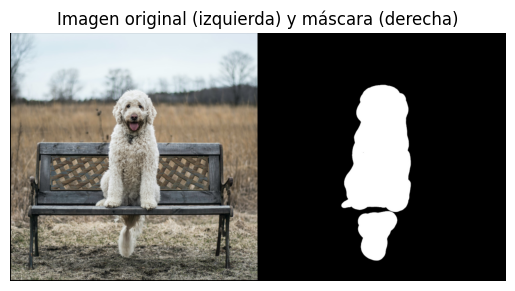

In [82]:
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image_from_url(image_url, mode="RGB")
mask = load_image_from_url(mask_url,  mode="L")

# Visualización de la imagen basal y máscara:
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image)
mask_tensor = to_tensor(mask)
mask_tensor = mask_tensor.expand(3, -1, -1)
grid = utils.make_grid([image_tensor, mask_tensor], nrow=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Imagen original (izquierda) y máscara (derecha)")
plt.show()

In [83]:
prompt = "A yellow cat sitting on a park bench"
inpainting(prompt, image, mask, guidance_scale=8)